<a href="https://colab.research.google.com/github/ReubenCode/TensorFlow/blob/main/04_transfer_learning_pt1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with tensorflow part 1: feature extraction

transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benfits
1. leverage an exisiting neural architecture proven to work on problems similar to our down
2. can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adap those patterns to our own

In [1]:
# check GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## download and become one with data

In [2]:
#get data (10% of 10 food classess from food 101)
import zipfile

#download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip the download file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-05-30 04:33:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.65.80, 172.217.12.240, 172.217.15.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.65.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   183MB/s    in 0.9s    

2022-05-30 04:33:45 (183 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# how many images in each folder
import os

#walk through 10 percent data directory and list of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 10 directori

## Creating data loaders (preparing the data)

we'll use the ImageDataGenerator class to load in our images in batch

In [4]:
#set data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = "categorical")
print("testing images")
test_data = test_datagen.flow_from_directory(test_dir,
                                                        target_size = IMAGE_SHAPE,
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = "categorical")

Training images:
Found 750 images belonging to 10 classes.
testing images
Found 2500 images belonging to 10 classes.


## setting up callbacks ( things to run while our model trains)

Callbacks are extra functiionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* tracking experiments with tensorboard callbacks
* model checkpoint with the ModelCheckpoint callback
* stopping a model from training (before it trains to long and overfits) with the EarlyStopping callback

In [5]:
# create TensorBoard callback (funcionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%y%m%d-%H%M%s")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

**Note** you can customize the directory where your tensorboard (model training metrics) gets saved to whatever you like. The log_dir parameter we've created above is only one option

## Creating models using TensorFlow Hub

Now we're a majority of our models are going to come from TensorFlow Hub

access pretrained models on https://tfhub.dev/

browsing TesorFlow hub page we found the following feature vector model link
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
#let's compare the following two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [8]:
# let's make a create_movel() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  takes a tensorflow hub url and creates a keras sequential model with it

  Args:
    model_url (str): a tensorflow ub feature extraction url.
    num_classes (int): number of output neurons in the output layer,
      should be equal to the number of target classes, default 10.
    
  Returns:
    An uncompiled keras sequential model with model_url sa feature extractor 
    layer and dense output layer with num_classes output layer
  """
  # download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False, #freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) 
  # CREATE OUR MODEL
  model = tf.keras.Sequential([
      feature_extractor_layer,  
      layers.Dense(num_classes, activation="softmax", name="output_layer")                       
  ])
  return model


###creating resnet tensorflow hub feature extraction model

In [9]:
#create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [10]:
# compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
# fit the Resnet model to the data
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50v2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50v2/220530-04341653885241
Epoch 1/5
24/24 [==============================] - 415s 18s/step - loss: 1.9943 - accuracy: 0.3533 - val_loss: 1.1618 - val_accuracy: 0.6376
Epoch 2/5
24/24 [==============================] - 410s 18s/step - loss: 0.9115 - accuracy: 0.7320 - val_loss: 0.8441 - val_accuracy: 0.7328
Epoch 3/5
24/24 [==============================] - 439s 19s/step - loss: 0.6302 - accuracy: 0.8333 - val_loss: 0.7337 - val_accuracy: 0.7700
Epoch 4/5
24/24 [==============================] - 388s 17s/step - loss: 0.4753 - accuracy: 0.8800 - val_loss: 0.6985 - val_accuracy: 0.7692
Epoch 5/5
24/24 [==============================] - 414s 18s/step - loss: 0.3804 - accuracy: 0.9133 - val_loss: 0.6657 - val_accuracy: 0.7856


transfer learning extractor out performed all of our training models, quicker and with less data

In [22]:
# function to plot loss curves
import matplotlib.pyplot as plt

#plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  args:
    history: TensorFlow History object.
  
  Returns:
    Plots of training/validation loss and accuracy

  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();


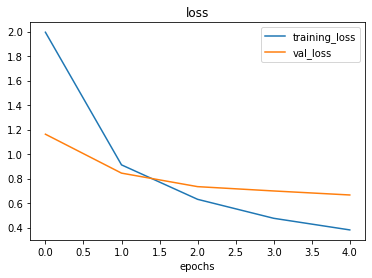

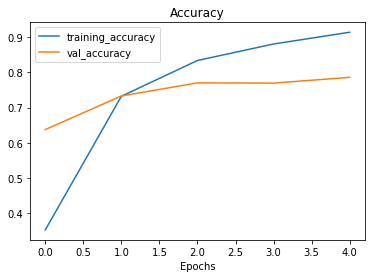

In [23]:
plot_loss_curves(resnet_history)

##Creating and testing EfficientNetb0 TensorFlow Hub Feature Extraction model

In [27]:
# create EfficientNetb0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)
#compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

#fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/220530-05351653888949
Epoch 1/5
24/24 [==============================] - 185s 8s/step - loss: 1.8444 - accuracy: 0.4520 - val_loss: 1.2956 - val_accuracy: 0.7476
Epoch 2/5
24/24 [==============================] - 143s 6s/step - loss: 1.0426 - accuracy: 0.7973 - val_loss: 0.8581 - val_accuracy: 0.8192
Epoch 3/5
24/24 [==============================] - 146s 6s/step - loss: 0.7417 - accuracy: 0.8440 - val_loss: 0.6891 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 144s 6s/step - loss: 0.5933 - accuracy: 0.8760 - val_loss: 0.6059 - val_accuracy: 0.8496
Epoch 5/5
24/24 [==============================] - 176s 8s/step - loss: 0.5036 - accuracy: 0.8907 - val_loss: 0.5530 - val_accuracy: 0.8608


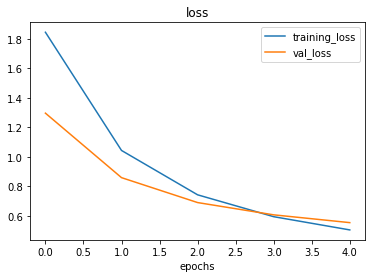

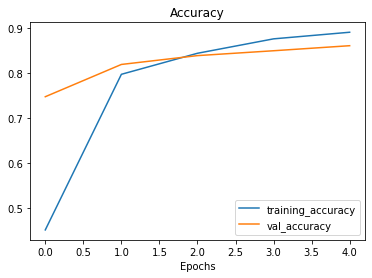

In [28]:
plot_loss_curves(efficientnet_history)

In [29]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [30]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of transfer learning
* **"as in" transfer** learning - using an existing model with no changes what so ever (e.g using ImageNet model on 1000 ImageNet classes, none of your own)
* **" Feature extraction"** transfer learning - use prelearned patterns of an existing model (e.g EfficientNetb0 trained on ImageNet) and adjusting the output layer for your own problem (e.g 1000 classes -> 10 classes of food)
* **"Fine-tuning"** transfer learning - use the prelearned patters of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

In [31]:
#how many layers does our efficientnet feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Comparing our models results using TensorBoard

**Note** uploading to TensorBoard.dev makes your experiments public.

In [ ]:
#upload TensorBoard
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EfficientNetb0 vs ResNet50v2" \
--description "Comparing two different TF hub feature extraction model architectures using 10% of the data" \
--one_shot

TensorBoard experiments are uploaded publically here https://tensorboard.dev/experiment/aWoN64LjToGdjhed0qrWKg/

In [33]:
# check out what TensorBoard experiments you have
!tensorboard dev list

2022-05-30 06:01:01.786567: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
https://tensorboard.dev/experiment/aWoN64LjToGdjhed0qrWKg/
	Name                 EfficientNetb0 vs ResNet50v2
	Description          Comparing two different TF hub feature extraction model architectures using 10% of the data
	Id                   aWoN64LjToGdjhed0qrWKg
	Created              2022-05-30 05:55:45 (5 minutes ago)
	Updated              2022-05-30 05:55:47 (5 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5921438
Total: 1 experiment(s)


In [ ]:
# Delete an experiment
#!tensorboard dev delete --experiment_id aWoN64LjToGdjhed0qrWKg

In [ ]:
# confirm the deletion by re-checking what experiments you have left
#!tensorboard dev list